In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [7]:
import os 
from IPython.display import Image, display
from deepagents import create_deep_agent
from langchain_openai import ChatOpenAI
from pydantic import SecretStr

# Model Claude 4.5
# model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

# use openrouter for cheap, efficient models
model = ChatOpenAI(
    model="x-ai/grok-4.1-fast", 
    
    # redirect LangChain to OpenRouter
    base_url="https://openrouter.ai/api/v1",

    # pass the OpenRouter key
    api_key=SecretStr(os.environ["OPENROUTER_API_KEY"])
)

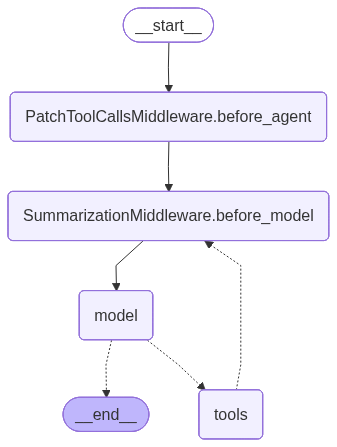

In [8]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [9]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research context engineering approaches used to build AI agents",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research context engineering approaches used to build AI agents                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to `/research_request.md`",                                 │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent sub-agent",                                                                                      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report writing",                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to `/final_report.md` following Report Writing Guidelines    │
│ (use overview/summary structure with sections, paragraphs, inline citations [1], and ### Sources at end)",      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report by reading `/research_request.md` and `/final_report.md`, confirm all aspects   │
│ addressed with citations and structure",                                                                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_86256868                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to `/research_request.md`", 'status':      │
│ 'in_progress'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a │
│ single research-agent sub-agent", 'status': 'pending'}, {'content': 'Synthesize sub-agent findings, consolidate │
│ unique citations (assign sequential numbers to unique URLs), and prepare for report writing', 'status':         │
│ 'pending'}, {'content': 'Write comprehensive final report to `/final_report.md` following Report Writing        │
│ Guidelines (use overview/summary structure with sections, paragraphs, inline citations [1], and ### Sources at  │
│ end)', 'status': 'pending'}, {'content': 'Verify report by reading `/research_request.md` and                   │
│ `/final_report.md`, confirm all aspects addressed with citations and structure', 'status': 'pending'}]          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to `/research_request.md`",                                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent sub-agent",                                                                                      │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report writing",                                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to `/final_report.md` following Report Writing Guidelines    │
│ (use overview/summary structure with sections, paragraphs, inline citations [1], and ### Sources at end)",      │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report by reading `/research_request.md` and `/final_report.md`, confirm all aspects   │
│ addressed with citations and structure",                                                                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_38268283                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: task                                       

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to `/research_request.md`", 'status':      │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent sub-agent", 'status': 'in_progress'}, {'content': 'Synthesize sub-agent findings,         │
│ consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report writing',       │
│ 'status': 'pending'}, {'content': 'Write comprehensive final report to `/final_report.md` following Report      │
│ Writing Guidelines (use overview/summary structure with sections, paragraphs, inline citations [1], and ###     │
│ Sources at end)', 'status': 'pending'}, {'content': 'Verify report by reading `/research_request.md` and        │
│ `/final_report.md`, confirm all aspects addressed with citations and structure', 'status': 'pending'}]          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## Definition of Context Engineering                                                                            │
│                                                                                                                 │
│ Context engineering is the systematic discipline of designing, organizing, orchestrating, and optimizing the    │
│ complete informational payload provided to a Large Language Model (LLM) at inference time, transcending         │
│ single-turn prompt crafting to encompass the entire information ecosystem—including memory, retrieved           │
│ documents, tools, and system instructions—that enables accurate, reliable, and consistent task performance      │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/). It reframes AI      │
│ development from "prompt engineering" (static instructions) to systems architecture, treating the LLM as a CPU  │
│ and the context window as RAM in an operating system analogy, where developers manage loading relevant data     │
│ dynamically to differentiate enterprise AI via proprietary knowledge                                            │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/)                      │
│ [Thenewstack](https://thenewstack.io/context-engineering-the-foundation-for-reliable-ai-agents/). This shift    │
│ addresses limitations of prompt engineering in stateful, multi-turn agent applications, ensuring the model      │
│ receives the right data in the right format at the right time                                                   │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/).                     │
│                                                                                                                 │
│ ## Key Techniques and Methods                                                                                   │
│                                                                                                                 │
│ Core techniques include **prompt engineering** via system-level instructions defining agent persona, behavior,  │
│ and constraints (e.g., "Act as a legal assistant, cite clauses, avoid financial advice")                        │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/). **Memory            │
│ management** bifurcates into short-term (conversational history summarization to fit context windows) and       │
│ long-term (vector database storage for cross-session recall of user preferences)                                │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/)                      │
│ [Thenewstack](https://thenewstack.io/context-engineering-the-foundation-for-reliable-ai-agents/). **Tool        │
│ integration** provides structured tool definitions (e.g., API schemas) and outputs, enabling actions like API   │
│ calls, with security via sandboxing (Docker/gVisor)                                                             │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/). **State             │
│ management** in agents uses scratchpads for intermediate reasoning, shared state in multi-agent graphs (e.g.,   │
│ LangGraph), and context orchestration like hybrid RAG (BM25 + vector search), re-ranking (cross-encoders),      │
│ Graph-RAG (entity relationships), and contextual retrieval (prepending summaries)                               │
│ (https://ikala.ai/blog/ai-trends/context-engineering-techniques-tools-and-implementation/). Context             │
│ optimization counters window limits via compression (selective pruning, recurrent methods), summarization       │
│ (extractive/abstractive), and pruning (e.g., Provence f

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to `/research_request.md`",                                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent sub-agent",                                                                                      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report writing",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to `/final_report.md` following Report Writing Guidelines    │
│ (use overview/summary structure with sections, paragraphs, inline citations [1], and ### Sources at end)",      │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report by reading `/research_request.md` and `/final_report.md`, confirm all aspects   │
│ addressed with citations and structure",                                                                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_27009680                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to `/research_request.md`", 'status':      │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent sub-agent", 'status': 'completed'}, {'content': 'Synthesize sub-agent findings,           │
│ consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report writing',       │
│ 'status': 'completed'}, {'content': 'Write comprehensive final report to `/final_report.md` following Report    │
│ Writing Guidelines (use overview/summary structure with sections, paragraphs, inline citations [1], and ###     │
│ Sources at end)', 'status': 'in_progress'}, {'content': 'Verify report by reading `/research_request.md` and    │
│ `/final_report.md`, confirm all aspects addressed with citations and structure', 'status': 'pending'}]          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to `/research_request.md`",                                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent sub-agent",                                                                                      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report writing",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to `/final_report.md` following Report Writing Guidelines    │
│ (use overview/summary structure with sections, paragraphs, inline citations [1], and ### Sources at end)",      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report by reading `/research_request.md` and `/final_report.md`, confirm all aspects   │
│ addressed with citations and structure",                                                                        │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_14785247                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                  

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to `/research_request.md`", 'status':      │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent sub-agent", 'status': 'completed'}, {'content': 'Synthesize sub-agent findings,           │
│ consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report writing',       │
│ 'status': 'completed'}, {'content': 'Write comprehensive final report to `/final_report.md` following Report    │
│ Writing Guidelines (use overview/summary structure with sections, paragraphs, inline citations [1], and ###     │
│ Sources at end)', 'status': 'completed'}, {'content': 'Verify report by reading `/research_request.md` and      │
│ `/final_report.md`, confirm all aspects addressed with citations and structure', 'status': 'in_progress'}]      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Research Request\n\nresearch context engineering approaches used to build AI agents                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Context Engineering Approaches for Building AI Agents                                                 │
│      2                                                                                                          │
│      3  ## Overview of Context Engineering                                                                      │
│      4                                                                                                          │
│      5  Context engineering represents a systematic discipline focused on designing, organizing, orchestrating, │
│ and optimizing the full informational payload delivered to a large language model (LLM) during inference. This  │
│ approach extends beyond traditional single-turn prompt crafting to manage the entire ecosystem of information,  │
│ including memory, retrieved documents, tools, and system instructions, ensuring accurate, reliable, and         │
│ consistent performance in AI agents [1]. It conceptualizes the LLM as a central processing unit (CPU) with the  │
│ context window functioning like random access memory (RAM), where developers dynamically load relevant data to  │
│ enhance enterprise AI capabilities through proprietary knowledge integration [1][3]. This evolution from prompt │
│ engineering addresses the needs of stateful, multi-turn applications by delivering the right data in the        │
│ appropriate format at the precise moment [1].                                                                   │
│      6                                                                                                          │
│      7  ## Key Techniques and Methods                                                                           │
│      8                                                                                                          │
│      9  Essential techniques in context engineering encompass several core areas. Prompt engineering            │
│ establishes system-level instructions that define the agent's persona, behavior, and constraints, such as       │
│ directing it to act as a legal assistant while citing specific clauses and avoiding unrelated advice [1].       │
│ Memory management divides into short-term mechanisms, like summarizing conversational history to fit within     │
│ context limits, and long-term solutions using vector databases for persistent recall of user preferences across │
│ sessions [1][3]. Tool integration involves providing structured definitions, such as API schemas, along with    │
│ secure execution environments like sandboxed Docker or gVisor containers to enable actions without risks [1].   │
│ State management employs scratchpads for intermediate reasoning, shared states in multi-agent graphs, and       │
│ advanced retrieval methods including hybrid retrieval-augmented generation (RAG) combining BM25 and vector      │
│ search, re-ranking with cross-encoders, Graph-RAG for entity relationships, and contextual retrieval via        │
│ prepended summaries [1]. Optimization strategies mitigate context window constraints through compression        │
│ techniques like selective pruning, recurrent summarization, and tools such as Provence for removing irrelevant  │
│ content [1][3].                                                                                                 │
│     10                                                                                                          │
│     11  ## Examples from Popular AI Agent Frameworks                                                            │
│     12                                                                                                          │
│     13  Prominent frameworks illustrate context engineering in practice. LangChain and its LangGraph extension  │
│ utilize modular components including ConversationBuffer

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save the user's research question to `/research_request.md`",                                 │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Delegate research on 'context engineering approaches used to build AI agents' to a single     │
│ research-agent sub-agent",                                                                                      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize sub-agent findings, consolidate unique citations (assign sequential numbers to     │
│ unique URLs), and prepare for report writing",                                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Write comprehensive final report to `/final_report.md` following Report Writing Guidelines    │
│ (use overview/summary structure with sections, paragraphs, inline citations [1], and ### Sources at end)",      │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Verify report by reading `/research_request.md` and `/final_report.md`, confirm all aspects   │
│ addressed with citations and structure",                                                                        │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: call_83579754                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': "Save the user's research question to `/research_request.md`", 'status':      │
│ 'completed'}, {'content': "Delegate research on 'context engineering approaches used to build AI agents' to a   │
│ single research-agent sub-agent", 'status': 'completed'}, {'content': 'Synthesize sub-agent findings,           │
│ consolidate unique citations (assign sequential numbers to unique URLs), and prepare for report writing',       │
│ 'status': 'completed'}, {'content': 'Write comprehensive final report to `/final_report.md` following Report    │
│ Writing Guidelines (use overview/summary structure with sections, paragraphs, inline citations [1], and ###     │
│ Sources at end)', 'status': 'completed'}, {'content': 'Verify report by reading `/research_request.md` and      │
│ `/final_report.md`, confirm all aspects addressed with citations and structure', 'status': 'completed'}]        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Context Engineering Approaches for Building AI Agents                                                         │
│                                                                                                                 │
│ ## Overview of Context Engineering                                                                              │
│                                                                                                                 │
│ Context engineering represents a systematic discipline focused on designing, organizing, orchestrating, and     │
│ optimizing the full informational payload delivered to a large language model (LLM) during inference. This      │
│ approach extends beyond traditional single-turn prompt crafting to manage the entire ecosystem of information,  │
│ including memory, retrieved documents, tools, and system instructions, ensuring accurate, reliable, and         │
│ consistent performance in AI agents [1]. It conceptualizes the LLM as a central processing unit (CPU) with the  │
│ context window functioning like random access memory (RAM), where developers dynamically load relevant data to  │
│ enhance enterprise AI capabilities through proprietary knowledge integration [1][3]. This evolution from prompt │
│ engineering addresses the needs of stateful, multi-turn applications by delivering the right data in the        │
│ appropriate format at the precise moment [1].                                                                   │
│                                                                                                                 │
│ ## Key Techniques and Methods                                                                                   │
│                                                                                                                 │
│ Essential techniques in context engineering encompass several core areas. Prompt engineering establishes        │
│ system-level instructions that define the agent's persona, behavior, and constraints, such as directing it to   │
│ act as a legal assistant while citing specific clauses and avoiding unrelated advice [1]. Memory management     │
│ divides into short-term mechanisms, like summarizing conversational history to fit within context limits, and   │
│ long-term solutions using vector databases for persistent recall of user preferences across sessions [1][3].    │
│ Tool integration involves providing structured definitions, such as API schemas, along with secure execution    │
│ environments like sandboxed Docker or gVisor containers to enable actions without risks [1]. State management   │
│ employs scratchpads for intermediate reasoning, shared states in multi-agent graphs, and advanced retrieval     │
│ methods including hybrid retrieval-augmented generation (RAG) combining BM25 and vector search, re-ranking with │
│ cross-encoders, Graph-RAG for entity relationships, and contextual retrieval via prepended summaries [1].       │
│ Optimization strategies mitigate context window constraints through compression techniques like selective       │
│ pruning, recurrent summarization, and tools such as Provence for removing irrelevant content [1][3].            │
│                                                                                                                 │
│ ## Examples from Popular AI Agent Frameworks                                                                    │
│                                                                                                                 │
│ Prominent frameworks illustrate context engineering in practice. LangChain and its LangGraph extension utilize  │
│ modular components including ConversationBufferMemory for short-term state persistence, FAISS vector stores for │
│ long-term memory, EnsembleRetrievers for hybrid RAG, an

In [10]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Context Engineering Approaches for Building AI Agents                                                        │
│                                                                                                                 │
│  ## Overview of Context Engineering                                                                             │
│                                                                                                                 │
│  Context engineering represents a systematic discipline focused on designing, organizing, orchestrating, and    │
│  optimizing the full informational payload delivered to a large language model (LLM) during inference. This     │
│  approach extends beyond traditional single-turn prompt crafting to manage the entire ecosystem of              │
│  information, including memory, retrieved documents, tools, and system instructions, ensuring accurate,         │
│  reliable, and consistent performance in AI agents [1]. It conceptualizes the LLM as a central processing unit  │
│  (CPU) with the context window functioning like random access memory (RAM), where developers dynamically load   │
│  relevant data to enhance enterprise AI capabilities through proprietary knowledge integration [1][3]. This     │
│  evolution from prompt engineering addresses the needs of stateful, multi-turn applications by delivering the   │
│  right data in the appropriate format at the precise moment [1].                                                │
│                                                                                                                 │
│  ## Key Techniques and Methods                                                                                  │
│                                                                                                                 │
│  Essential techniques in context engineering encompass several core areas. Prompt engineering establishes       │
│  system-level instructions that define the agent's persona, behavior, and constraints, such as directing it to  │
│  act as a legal assistant while citing specific clauses and avoiding unrelated advice [1]. Memory management    │
│  divides into short-term mechanisms, like summarizing conversational history to fit within context limits, and  │
│  long-term solutions using vector databases for persistent recall of user preferences across sessions [1][3].   │
│  Tool integration involves providing structured definitions, such as API schemas, along with secure execution   │
│  environments like sandboxed Docker or gVisor containers to enable actions without risks [1]. State management  │
│  employs scratchpads for intermediate reasoning, shared states in multi-agent graphs, and advanced retrieval    │
│  methods including hybrid retrieval-augmented generation (RAG) combining BM25 and vector search, re-ranking     │
│  with cross-encoders, Graph-RAG for entity relationships, and contextual retrieval via prepended summaries      │
│  [1]. Optimization strategies mitigate context window constraints through compression techniques like           │
│  selective pruning, recurrent summarization, and tools such as Provence for removing irrelevant content         │
│  [1][3].                                                                                                        │
│                                                                                                                 │
│  ## Examples from Popular AI Agent Frameworks                                                                   │
│                                                                                                                 │
│  Prominent frameworks illustrate context engineering i